In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u

import os
gd_folder = os.getcwd()+"/../../Calculations/Gas_and_dust/"

import sys 
sys.path.append(gd_folder)
from polWaveDust import PolWaveDust
from polWaveGas import PolWaveGas

In [2]:
dust_type = "SMC"
pw = PolWaveDust("SMC", interp_method='linear')

In [3]:
pw.p_grid.shape

(105, 36, 37)

In [12]:
# p_meas = 0.1109
# p_err = 0.0023
# lam_targ = 6501*u.AA/(1+3.173)
# p_meas = 0.1430
# p_err = 0.0045
# lam_targ = 7908*u.AA/(1+3.173)
p_meas = 0.0959
p_err = 0.0040
lam_targ = 5532*u.AA/(1+3.173)

psi_grid   = np.arange(pw.psi_grid.min().value  , pw.psi_grid.max().value  , 0.5)*u.deg
theta_grid = np.arange(pw.theta_grid.min().value, pw.theta_grid.max().value, 0.5)*u.deg
p_map = np.ma.zeros((len(theta_grid), len(psi_grid)))
p_map.mask = np.zeros(p_map.shape, dtype=bool)
for i, th in enumerate(theta_grid):
    for j, psi in enumerate(psi_grid):
        if th<psi:
            p_map[i,j] = np.nan
            p_map.mask[i,j] = True
        else:
            p_map[i,j] = pw.p((lam_targ, th, psi))
chi2_map = ((p_map-p_meas)/p_err)**2

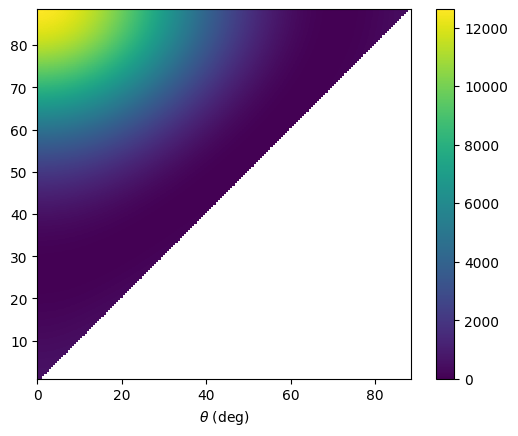

In [13]:
fig, ax = plt.subplots(1)
x0 = pw.psi_grid[0].value
x1 = pw.psi_grid[-1].value
y0 = pw.theta_grid[0].value
y1 = pw.theta_grid[-1].value
cm = ax.imshow(chi2_map, origin='lower', extent=[x0,x1,y0,y1])
ax.set_xlabel(r'$\psi~(\rm deg)$')
ax.set_xlabel(r'$\theta~(\rm deg)$')
fig.colorbar(cm)
plt.show()

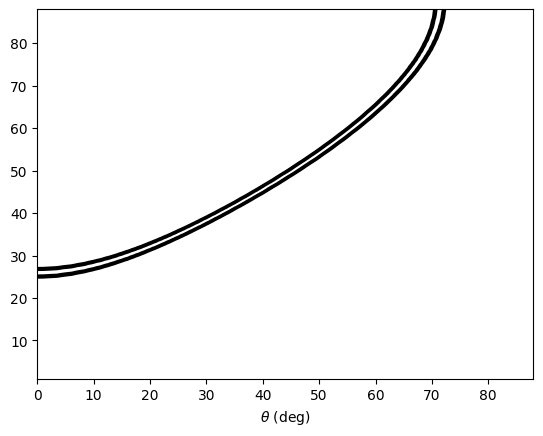

In [14]:
fig, ax = plt.subplots(1)

ax.contour(psi_grid,theta_grid,chi2_map, levels=[1., 2., 3.], colors='black')
           
ax.set_xlabel(r'$\psi~(\rm deg)$')
ax.set_xlabel(r'$\theta~(\rm deg)$')

plt.show()

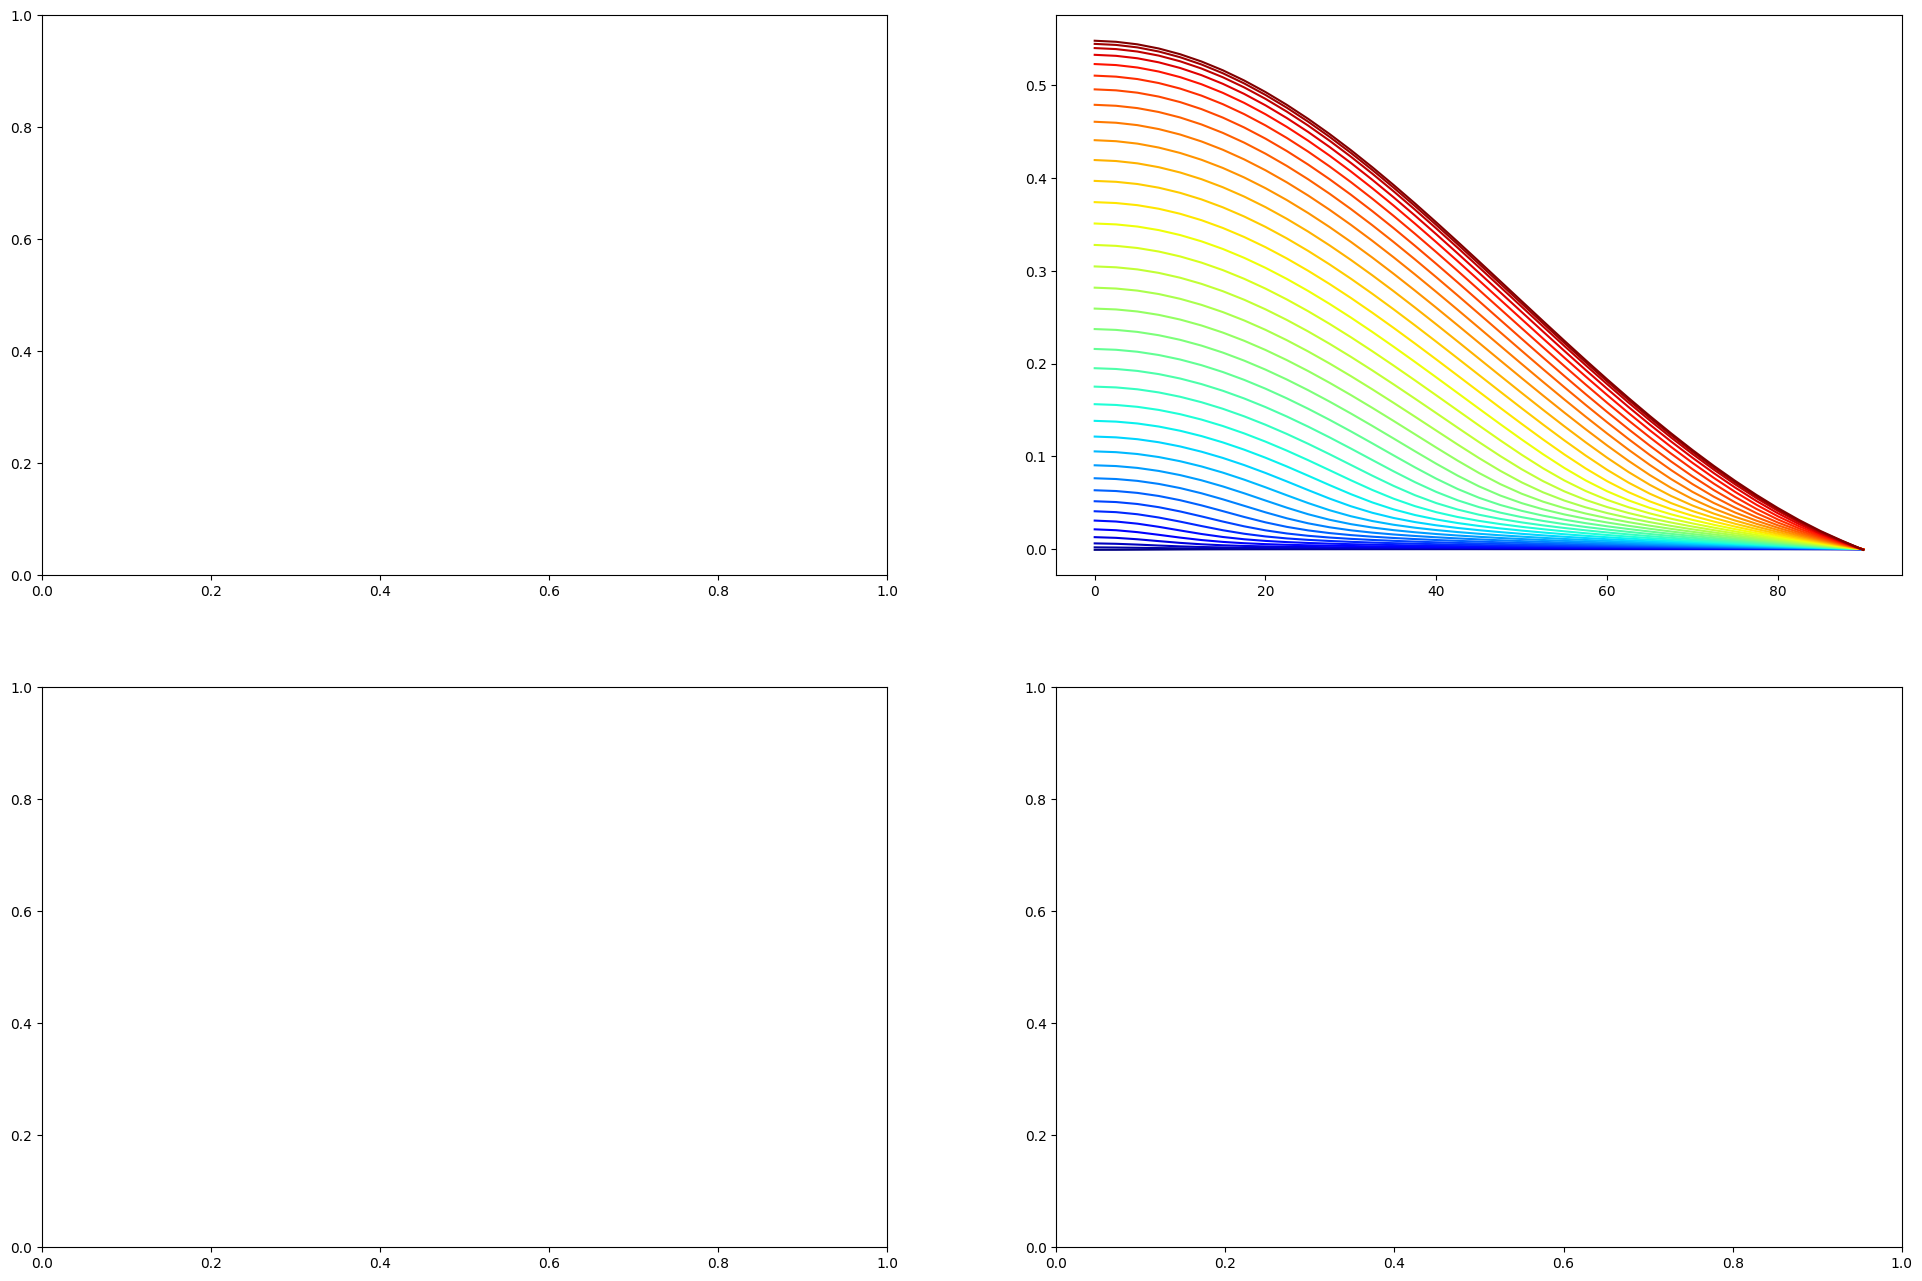

In [15]:
ths = np.arange(0., 90.1, 2.5)
psis = np.arange(0., 90.1, 2.5)

Norm = mpl.colors.Normalize(vmin=ths[0], vmax=ths[-1])
cmap = mpl.cm.jet

fig, axs = plt.subplots(2, 2, figsize=(24,16))
for th in ths:
    c = cmap(Norm(th))
    p_aux = pw.p((lam_targ*np.ones(len(psis)), th*np.ones(len(psis)), psis))
    axs[0,1].plot(psis, p_aux, color=c, ls='solid')